In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import matplotlib.pyplot as plt
import sys, random
sys.path.append('/Users/fbianchini/Research/FlatSpec/')
from Spec2D import *
from Sims import *
from cosmojo.universe import Cosmo
from cosmojo.utils import nl_cmb

In [2]:
# Generate theoretical CMB power spectrum and noise

noise_muK_arcmin = 20.
beam = 1.

cltt = Cosmo(lmax=8000).cmb_spectra(8000, dl=False)[:,0]
nltt = nl_cmb(noise_muK_arcmin, 0., lmax=10000) # 20 \muK, no beam because I smooth later
nltt_1f = nl_cmb(noise_muK_arcmin, 0., lmax=10000, lknee=300, alpha=2.)


/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:350: RuntimeWarning: divide by zero encountered in divide
  fact = 2.*np.pi/(ls*(ls+1)) * 1.e12 * self.pars.TCMB**2.
/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:358: RuntimeWarning: invalid value encountered in multiply
  cls[:,i] *= fact
/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/utils.py:48: RuntimeWarning: divide by zero encountered in divide
  return  ((noise_uK_arcmin * np.pi/180./60.)**2 / bl(fwhm_arcmin, lmax=lmax)**2) * (1. + (lknee/ls)**alpha)


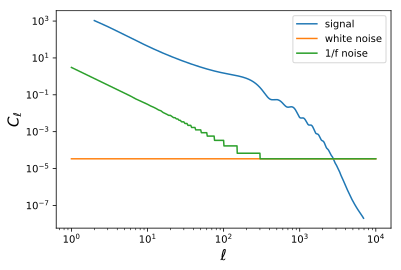

In [3]:
plt.loglog(cltt, label='signal')
plt.loglog(nltt, label='white noise')
plt.loglog(nltt_1f, label='1/f noise')
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$C_{\ell}$', size=15)

In [4]:
arcmin2rad = np.pi / 180. / 60. 


def GetCutout(pixmap, pixcent, npix):
    """
    Extracts a cutout of size (npix,npix) centered in (pixcent[0], pixcent[1]) from a bigger map pixmap
    """
    x, y = pixcent
    x, y = np.int(x), np.int(y)
    return pixmap[y-npix:y+npix+1, x-npix:x+npix+1]

def GoGetStack(x, y, skymap, mask, npix):
    results = {}
    results['maps'] = []
    
    for i in xrange(len(x)):
        cutmask = GetCutout(mask, (x[i],y[i]), npix=npix)
#         print cutmask.shape
        isgood = True if (np.mean(cutmask) == 1) & (cutmask.shape == (2*npix+1,2*npix+1)) else False # Do analysis if all the cutout within the footprint

#         print x[i], y[i], isgood, np.mean(cutmask)

        if isgood: # Cutout is *completely* in the footprint
            results['maps'].append(GetCutout(skymap, (x[i],y[i]), npix=npix))
        else: # discard object
            pass

    results['maps'] = np.asarray(results['maps'])			
    
    return results

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x=1, sigma_y=1, theta=0., offset=0):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g#.ravel()

def Add2dGauss(x, y, data, npix, amp=5.):
    for i in xrange(len(x)):
        X, Y = np.meshgrid(np.arange(y[i]-npix, y[i]+npix+1), np.arange(x[i]-npix, x[i]+npix+1))
#         X -= x[i]
#         Y -= y[i]
#         plt.imshow(twoD_Gaussian((X,Y), amplitude=amp, xo=x[i], yo=y[i]))
        try:
            data[y[i]-npix:y[i]+npix+1, x[i]-npix:x[i]+npix+1] += twoD_Gaussian((Y,X), amplitude=amp, xo=x[i], yo=y[i], sigma_x=1, sigma_y=1)
        except:
            pass
    return data

def FilterMap(pixmap, lmin, lmax, reso, pad=1):
    if pad !=1:
        pixmap = np.pad(pixmap, ((pixmap.shape[0], pixmap.shape[0])), mode='constant', constant_values=0.)
    
    ft = np.fft.fftshift(np.fft.fft2(pixmap))
    mask = GetLMask(pixmap.shape[0], dx=reso, lmin=lmin, lmax=lmax, shift=True)
    
    return np.fft.ifft2(np.fft.fftshift(ft*mask)).real
    
def GetLMask(nx, dx, shift=False, lmin=None, lmax=None):
    """ 
    return a Fourier mask for the pixelization associated with this object which is zero over customizable ranges of L. 
    """
    mask      = np.ones((nx, nx), dtype=np.complex)
    lx, ly    = GetLxLy(nx, dx, shift=shift)
    L         = GetL(nx, dx, shift=shift)
    if lmin  != None: mask[ np.where(L < lmin) ] = 0.0
    if lmax  != None: mask[ np.where(L >=lmax) ] = 0.0
    return mask

def GetLxLy(nx, dx, shift=True):
    """ 
    Returns two grids with the (lx, ly) pair associated with each Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    ~ Note: already multiplied by 2\pi 
    """
    dx *= arcmin2rad
    if shift:
        return np.meshgrid( np.fft.fftshift(np.fft.fftfreq(nx, dx))*2.*np.pi, np.fft.fftshift(np.fft.fftfreq(nx, dx))*2.*np.pi )
    else:
        return np.meshgrid( np.fft.fftfreq(nx, dx)*2.*np.pi, np.fft.fftfreq(nx, dx)*2.*np.pi )


def GetL(nx, dx, shift=True):
    """ 
    Returns a grid with the wavenumber l = \sqrt(lx**2 + ly**2) for each Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    """
    lx, ly = GetLxLy(nx, dx, shift=shift)
    return np.sqrt(lx**2 + ly**2)


In [ ]:
# Creating maps at 0.5 arcmin/pix
tt = GenCorrFlatMaps(cltt, 3000, 0.5, buff=1, seed=666) # signal map
ntt = GenCorrFlatMaps(nltt, 3000, 0.5, buff=1, seed=1) # white-noise map
ntt_1f = GenCorrFlatMaps(nltt_1f, 3000, 0.5, buff=1, seed=1) # white-noise map

In [ ]:
beam = 1.

plt.figure(figsize=(12,10))

plt.subplot(221)
plt.title('Signal')
im = plt.imshow(GaussSmooth(tt,beam,0.5), extent=[-12.5, 12.5, 12.5, -12.5], cmap='Greys')#, vmin=-400,vmax=400)#[2400:2700,800:1200])
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [deg]')
plt.ylabel(r'$\Delta y$ [deg]')

plt.subplot(222)
plt.title('Signal + White Noise')
im = plt.imshow(GaussSmooth(tt,beam,0.5)+ntt, extent=[-12.5, 12.5, 12.5, -12.5],cmap='Greys')#, vmin=-400,vmax=400)#[2400:2700,800:1200])
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [deg]')
plt.ylabel(r'$\Delta y$ [deg]')

plt.subplot(223)
plt.title('Signal + White & 1/f Noise')
im = plt.imshow(GaussSmooth(tt,beam,0.5)+ntt_1f, extent=[-12.5, 12.5, 12.5, -12.5],cmap='Greys')#, vmin=-400,vmax=400)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [deg]')
plt.ylabel(r'$\Delta y$ [deg]')

plt.subplot(224)
plt.title('1/f Noise')
im = plt.imshow(ntt_1f-ntt, extent=[-12.5, 12.5, 12.5, -12.5],cmap='Greys')#, vmin=-400,vmax=400)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [deg]')
plt.ylabel(r'$\Delta y$ [deg]')

# plt.colorbar()

In [ ]:
# STACKING ON MAPS 

# Smoothing signal map
tt_smooth = GaussSmooth(tt, beam, 0.5)

nrnd = 10000 # number of random locations
nsrc = 2000  # number of point sources

np.random.seed(1988)

# Sources locations 
src_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nsrc)]
src_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nsrc)]

# Random locations 
rnd_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nrnd)]
rnd_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nrnd)]

print rnd_x[:5]

# Adding point sources (2DGauss w/ amplitude = 3. \muK)
tt_src = Add2dGauss(src_x, src_y, tt.copy(), 10, amp=3.)
tt_src_smooth = GaussSmooth(tt_src, beam, 0.5)

# Summing up maps
tot = tt_smooth + ntt
tot_1f = tt_smooth + ntt_1f

tot_src = tt_src_smooth + ntt
tot_src_1f = tt_src_smooth + ntt_1f

# Filter the maps
tot_src_filt = FilterMap(tt_src_smooth + ntt, 300, 10000, 0.5)
tot_src_1f_filt = FilterMap(tt_src_smooth + ntt_1f, 300, 10000, 0.5)



In [ ]:
# Stacking on random locations 
rnd_src_white = GoGetStack(rnd_x, rnd_y, tot_src, np.ones_like(tot), 10) # signal + src + white noise map
rnd_src_1f = GoGetStack(rnd_x, rnd_y, tot_src_1f, np.ones_like(tot), 10) # signal + src + white & 1/f noise map
rnd_src_white_filt = GoGetStack(rnd_x, rnd_y, tot_src_filt, np.ones_like(tot), 10) # signal + src + white noise FILTERED map 
rnd_src_1f_filt = GoGetStack(rnd_x, rnd_y, tot_src_1f_filt, np.ones_like(tot), 10) # signal + src + white & 1/f noise FILTERED map
rnd_white = GoGetStack(rnd_x, rnd_y, tot, np.ones_like(tot), 10)         # signal + white noise map
rnd_1f = GoGetStack(rnd_x, rnd_y, tot_1f, np.ones_like(tot), 10)         # signal + white & 1/f noise map

In [ ]:
# Plots stack on random locations

plt.figure(figsize=(10,12))

# RND_src_white = np.asarray([rnd_src_white['maps'][i]-rnd_src_white['maps'][i].mean() for i in xrange(rnd_src_white['maps'].shape[0])])
RND_src_white = np.asarray([rnd_src_white['maps'][i] for i in xrange(rnd_src_white['maps'].shape[0])])
plt.subplot(321)
im = plt.imshow(RND_src_white.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_white['maps'].shape[0])
plt.title(r'Random locs: signal + white noise + sources')

# RND_src_1f = np.asarray([rnd_src_1f['maps'][i]-rnd_src_1f['maps'][i].mean() for i in xrange(rnd_src_1f['maps'].shape[0])])
RND_src_1f = np.asarray([rnd_src_1f['maps'][i] for i in xrange(rnd_src_1f['maps'].shape[0])])
plt.subplot(322)
im = plt.imshow(RND_src_1f.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_1f['maps'].shape[0])
plt.title(r'Random locs: signal + white & 1/f noise + sources')


# RND_src_white = np.asarray([rnd_src_white['maps'][i]-rnd_src_white['maps'][i].mean() for i in xrange(rnd_src_white['maps'].shape[0])])
RND_src_white_filt = np.asarray([rnd_src_white_filt['maps'][i] for i in xrange(rnd_src_white_filt['maps'].shape[0])])
plt.subplot(323)
im = plt.imshow(RND_src_white_filt.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_white['maps'].shape[0])
plt.title(r'Random locs: FILT signal + white noise + sources')

# RND_src_1f = np.asarray([rnd_src_1f['maps'][i]-rnd_src_1f['maps'][i].mean() for i in xrange(rnd_src_1f['maps'].shape[0])])
RND_src_1f_filt = np.asarray([rnd_src_1f_filt['maps'][i] for i in xrange(rnd_src_1f_filt['maps'].shape[0])])
plt.subplot(324)
im = plt.imshow(RND_src_1f_filt.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_1f['maps'].shape[0])
plt.title(r'Random locs: FILT signal + white & 1/f noise + sources')

# RND_white = np.asarray([rnd_white['maps'][i]-rnd_white['maps'][i].mean() for i in xrange(rnd_white['maps'].shape[0])])
RND_white = np.asarray([rnd_white['maps'][i] for i in xrange(rnd_white['maps'].shape[0])])
plt.subplot(325)
im = plt.imshow(RND_white.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_white['maps'].shape[0])
plt.title(r'Random locs: signal + white noise')

# RND_1f = np.asarray([rnd_1f['maps'][i]-rnd_1f['maps'][i].mean() for i in xrange(rnd_1f['maps'].shape[0])])
RND_1f = np.asarray([rnd_1f['maps'][i] for i in xrange(rnd_1f['maps'].shape[0])])
plt.subplot(326)
im = plt.imshow(RND_1f.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_1f['maps'].shape[0])
plt.title(r'Random locs: signal + white & 1/f noise')


In [ ]:
# Stacking on sources locations 
src_white      = GoGetStack(src_x, src_y, tot_src, np.ones_like(tot), 10) # signal + src + white noise map
src_1f         = GoGetStack(src_x, src_y, tot_src_1f, np.ones_like(tot), 10) # signal + src + white & 1/f noise map
src_white_filt = GoGetStack(src_x, src_y, tot_src_filt, np.ones_like(tot), 10) # signal + src + white noise map
src_1f_filt    = GoGetStack(src_x, src_y, tot_src_1f_filt, np.ones_like(tot), 10) # signal + src + white & 1/f noise map


In [ ]:
# Plots stack on sources locations

plt.figure(figsize=(10,10))

LOC_src_white = src_white['maps'].mean(0) - RND_src_white.mean(0)
plt.subplot(221)
im = plt.imshow(LOC_src_white, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: mean stack - white noise stack')

LOC_src_1f = src_1f['maps'].mean(0) - RND_src_1f.mean(0)
plt.subplot(222)
im = plt.imshow(LOC_src_1f, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: mean stack - white & 1/f noise stack')

LOC_src_white_filt = src_white_filt['maps'].mean(0) - RND_src_white_filt.mean(0)
plt.subplot(223)
im = plt.imshow(LOC_src_white_filt, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: FILT mean stack - white noise stack')

LOC_src_1f_filt = src_1f_filt['maps'].mean(0) - RND_src_1f_filt.mean(0)
plt.subplot(224)
im = plt.imshow(LOC_src_1f_filt, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: FILT mean stack - white & 1/f noise stack')


In [ ]:
plt.subplot(121)
for i in xrange(LOC_src_white.shape[0]):
    plt.plot(LOC_src_white[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')
plt.ylim([-5,5])

plt.subplot(122)
for i in xrange(LOC_src_white_filt.shape[0]):
    plt.plot(LOC_src_white_filt[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')
plt.ylim([-5,5])

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(tot_src)#, extent=[-12.5, 12.5, 12.5, -12.5])#[2400:2700,800:1200])
plt.plot(rnd_x[:200], rnd_y[:200], 'wo', markerfacecolor='none')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [deg]')
plt.ylabel(r'$\Delta y$ [deg]')
plt.title(r'$\Delta_T=25\mu$K-arcmin - 0.5 arcmin/pix - 2000 pt src 3 $\mu$K')

In [ ]:
M = FlatMapReal(tot_src_1f.shape[0], 0.5, map=tot_src_1f)
M_filt = FlatMapReal(tot_src_1f_filt.shape[0], 0.5, map=tot_src_1f_filt)
FT = FlatMapFFT(tot_src_1f.shape[0], 0.5, map=M)

In [ ]:
l, cl = FT.GetCl(lbins=np.arange(2,10000,30), prefact=lambda l:l*(l+1) )
l_, cl_ = FT.GetCl(M_filt, lbins=np.arange(2,10000,30), prefact=lambda l:l*(l+1) )

In [ ]:
l_ = np.arange(len(cltt))
_l_ = np.arange(len(nltt_1f))
cltot = nltt_1f.copy()
cltot[:cltt.size] +=cltt
plt.loglog(_l_*(_l_+1)*cltot, '--', label=r'Signal+Noise')

plt.loglog(l, cl, '-', alpha=0.6,label=r'Reco')
plt.loglog(l, cl_, '-', alpha=0.6, label=r'Reco filtered')
plt.loglog(l_*(l_+1)*cltt, ':', label=r'Signal')
plt.xlim([10,1e4])
plt.ylim([3e2,4e4])
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$C_{\ell}$', size=15)

In [ ]:
# STACK ON WHITE NOISE MAP ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

M = np.random.randn(3000**2).reshape((3000,3000))

src_x = [random.uniform(0, M.shape[1]) for i in xrange(nsrc)]
src_y = [random.uniform(0, M.shape[0]) for i in xrange(nsrc)]

M_stack = GoGetStack(src_x, src_y, M, np.ones_like(M), 10)

plt.imshow(M);plt.colorbar()

In [ ]:
plt.imshow(M_stack['maps'].mean(0));plt.colorbar()

In [ ]:
for i in xrange(M_stack['maps'].mean(0).shape[0]):
    plt.plot(M_stack['maps'].mean(0)[i,:], alpha=0.4)
plt.axhline(ls='--', color='k')

In [ ]:
# STACKING ON different set of locations ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Smoothing signal map
tt_smooth = GaussSmooth(tt, beam, 0.5)

nrnd = 10000 # number of random locations
nsrc = 2000  # number of point sources

np.random.seed(69)

# Sources locations 
src_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nsrc)]
src_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nsrc)]

# Random locations 
rnd_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nrnd)]
rnd_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nrnd)]

print rnd_x[:5]

# Adding point sources (2DGauss w/ amplitude = 3. \muK)
tt_src = Add2dGauss(src_x, src_y, tt.copy(), 10, amp=3.)
tt_src_smooth = GaussSmooth(tt_src, beam, 0.5)

# Summing up maps
tot = tt_smooth + ntt
tot_1f = tt_smooth + ntt_1f

tot_src = tt_src_smooth + ntt
tot_src_1f = tt_src_smooth + ntt_1f

# Filter the maps
tot_src_filt = FilterMap(tt_src_smooth, 300, 10000, 0.5) + ntt
tot_src_1f_filt = FilterMap(tt_src_smooth, 300, 10000, 0.5)  + ntt_1f 

# Stacking on random locations 
rnd_src_white = GoGetStack(rnd_x, rnd_y, tot_src, np.ones_like(tot), 10) # signal + src + white noise map
rnd_src_1f = GoGetStack(rnd_x, rnd_y, tot_src_1f, np.ones_like(tot), 10) # signal + src + white & 1/f noise map
rnd_src_white_filt = GoGetStack(rnd_x, rnd_y, tot_src_filt, np.ones_like(tot), 10) # signal + src + white noise FILTERED map 
rnd_src_1f_filt = GoGetStack(rnd_x, rnd_y, tot_src_1f_filt, np.ones_like(tot), 10) # signal + src + white & 1/f noise FILTERED map
rnd_white = GoGetStack(rnd_x, rnd_y, tot, np.ones_like(tot), 10)         # signal + white noise map
rnd_1f = GoGetStack(rnd_x, rnd_y, tot_1f, np.ones_like(tot), 10)         # signal + white & 1/f noise map

# Stacking on sources locations 
src_white      = GoGetStack(src_x, src_y, tot_src, np.ones_like(tot), 10) # signal + src + white noise map
src_1f         = GoGetStack(src_x, src_y, tot_src_1f, np.ones_like(tot), 10) # signal + src + white & 1/f noise map
src_white_filt = GoGetStack(src_x, src_y, tot_src_filt, np.ones_like(tot), 10) # signal + src + white noise map
src_1f_filt    = GoGetStack(src_x, src_y, tot_src_1f_filt, np.ones_like(tot), 10) # signal + src + white & 1/f noise map



In [ ]:
# Plots stack on random locations

plt.figure(figsize=(10,12))

# RND_src_white = np.asarray([rnd_src_white['maps'][i]-rnd_src_white['maps'][i].mean() for i in xrange(rnd_src_white['maps'].shape[0])])
RND_src_white = np.asarray([rnd_src_white['maps'][i] for i in xrange(rnd_src_white['maps'].shape[0])])
plt.subplot(321)
im = plt.imshow(RND_src_white.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_white['maps'].shape[0])
plt.title(r'Random locs: signal + white noise + sources')

# RND_src_1f = np.asarray([rnd_src_1f['maps'][i]-rnd_src_1f['maps'][i].mean() for i in xrange(rnd_src_1f['maps'].shape[0])])
RND_src_1f = np.asarray([rnd_src_1f['maps'][i] for i in xrange(rnd_src_1f['maps'].shape[0])])
plt.subplot(322)
im = plt.imshow(RND_src_1f.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_1f['maps'].shape[0])
plt.title(r'Random locs: signal + white & 1/f noise + sources')


# RND_src_white = np.asarray([rnd_src_white['maps'][i]-rnd_src_white['maps'][i].mean() for i in xrange(rnd_src_white['maps'].shape[0])])
RND_src_white_filt = np.asarray([rnd_src_white_filt['maps'][i] for i in xrange(rnd_src_white_filt['maps'].shape[0])])
plt.subplot(323)
im = plt.imshow(RND_src_white_filt.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_white['maps'].shape[0])
plt.title(r'Random locs: FILT signal + white noise + sources')

# RND_src_1f = np.asarray([rnd_src_1f['maps'][i]-rnd_src_1f['maps'][i].mean() for i in xrange(rnd_src_1f['maps'].shape[0])])
RND_src_1f_filt = np.asarray([rnd_src_1f_filt['maps'][i] for i in xrange(rnd_src_1f_filt['maps'].shape[0])])
plt.subplot(324)
im = plt.imshow(RND_src_1f_filt.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_src_1f['maps'].shape[0])
plt.title(r'Random locs: FILT signal + white & 1/f noise + sources')

# RND_white = np.asarray([rnd_white['maps'][i]-rnd_white['maps'][i].mean() for i in xrange(rnd_white['maps'].shape[0])])
RND_white = np.asarray([rnd_white['maps'][i] for i in xrange(rnd_white['maps'].shape[0])])
plt.subplot(325)
im = plt.imshow(RND_white.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_white['maps'].shape[0])
plt.title(r'Random locs: signal + white noise')

# RND_1f = np.asarray([rnd_1f['maps'][i]-rnd_1f['maps'][i].mean() for i in xrange(rnd_1f['maps'].shape[0])])
RND_1f = np.asarray([rnd_1f['maps'][i] for i in xrange(rnd_1f['maps'].shape[0])])
plt.subplot(326)
im = plt.imshow(RND_1f.mean(0),cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
# plt.title(r'RND $N_{rnd}= %d$ locations'%rnd_1f['maps'].shape[0])
plt.title(r'Random locs: signal + white & 1/f noise')


In [ ]:
# Plots stack on sources locations

plt.figure(figsize=(10,10))

LOC_src_white = src_white['maps'].mean(0) - RND_src_white.mean(0)
plt.subplot(221)
im = plt.imshow(LOC_src_white, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: mean stack - white noise stack')

LOC_src_1f = src_1f['maps'].mean(0) - RND_src_1f.mean(0)
plt.subplot(222)
im = plt.imshow(LOC_src_1f, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: mean stack - white & 1/f noise stack')

LOC_src_white_filt = src_white_filt['maps'].mean(0) - RND_src_white_filt.mean(0)
plt.subplot(223)
im = plt.imshow(LOC_src_white_filt, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: FILT mean stack - white noise stack')

LOC_src_1f_filt = src_1f_filt['maps'].mean(0) - RND_src_1f_filt.mean(0)
plt.subplot(224)
im = plt.imshow(LOC_src_1f_filt, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: FILT mean stack - white & 1/f noise stack')
                                               

In [ ]:
plt.subplot(121)
for i in xrange(LOC_src_white.shape[0]):
    plt.plot(LOC_src_white[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')
plt.ylim([-5,5])

plt.subplot(122)
for i in xrange(LOC_src_white_filt.shape[0]):
    plt.plot(LOC_src_white_filt[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')
plt.ylim([-5,5])

In [ ]:
# STACKING ON L < 2000 FILTERED maps (first set of locations) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Smoothing signal map
tt_smooth = GaussSmooth(tt, beam, 0.5)

nrnd = 10000 # number of random locations
nsrc = 2000  # number of point sources

np.random.seed(1988)

# Sources locations 
src_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nsrc)]
src_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nsrc)]

# Random locations 
rnd_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nrnd)]
rnd_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nrnd)]

print rnd_x[:5]

# Adding point sources (2DGauss w/ amplitude = 3. \muK)
tt_src = Add2dGauss(src_x, src_y, tt.copy(), 10, amp=3.)
tt_src_smooth = GaussSmooth(tt_src, beam, 0.5)

# Summing up maps
tot = tt_smooth + ntt
tot_1f = tt_smooth + ntt_1f

tot_src = tt_src_smooth + ntt
tot_src_1f = tt_src_smooth + ntt_1f

# Filter the maps
tot_src_filt = FilterMap(tt_src_smooth, 2000, 10000, 0.5) + ntt
tot_src_1f_filt = FilterMap(tt_src_smooth, 2000, 10000, 0.5)  + ntt_1f 

# Stacking on random locations 
rnd_src_white = GoGetStack(rnd_x, rnd_y, tot_src, np.ones_like(tot), 10) # signal + src + white noise map
rnd_src_1f = GoGetStack(rnd_x, rnd_y, tot_src_1f, np.ones_like(tot), 10) # signal + src + white & 1/f noise map
rnd_src_white_filt = GoGetStack(rnd_x, rnd_y, tot_src_filt, np.ones_like(tot), 10) # signal + src + white noise FILTERED map 
rnd_src_1f_filt = GoGetStack(rnd_x, rnd_y, tot_src_1f_filt, np.ones_like(tot), 10) # signal + src + white & 1/f noise FILTERED map
rnd_white = GoGetStack(rnd_x, rnd_y, tot, np.ones_like(tot), 10)         # signal + white noise map
rnd_1f = GoGetStack(rnd_x, rnd_y, tot_1f, np.ones_like(tot), 10)         # signal + white & 1/f noise map

# Stacking on sources locations 
src_white      = GoGetStack(src_x, src_y, tot_src, np.ones_like(tot), 10) # signal + src + white noise map
src_1f         = GoGetStack(src_x, src_y, tot_src_1f, np.ones_like(tot), 10) # signal + src + white & 1/f noise map
src_white_filt = GoGetStack(src_x, src_y, tot_src_filt, np.ones_like(tot), 10) # signal + src + white noise map
src_1f_filt    = GoGetStack(src_x, src_y, tot_src_1f_filt, np.ones_like(tot), 10) # signal + src + white & 1/f noise map



In [ ]:
# Plots stack on sources locations

plt.figure(figsize=(10,10))

LOC_src_white = src_white['maps'].mean(0) - RND_src_white.mean(0)
plt.subplot(221)
im = plt.imshow(LOC_src_white, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: mean stack - white noise stack')

LOC_src_1f = src_1f['maps'].mean(0) - RND_src_1f.mean(0)
plt.subplot(222)
im = plt.imshow(LOC_src_1f, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: mean stack - white & 1/f noise stack')

LOC_src_white_filt = src_white_filt['maps'].mean(0) - RND_src_white_filt.mean(0)
plt.subplot(223)
im = plt.imshow(LOC_src_white_filt, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: FILT mean stack - white noise stack')

LOC_src_1f_filt = src_1f_filt['maps'].mean(0) - RND_src_1f_filt.mean(0)
plt.subplot(224)
im = plt.imshow(LOC_src_1f_filt, cmap='Greys')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title(r'Source locs: FILT mean stack - white & 1/f noise stack')
                                               

In [ ]:
plt.subplot(121)
for i in xrange(LOC_src_white.shape[0]):
    plt.plot(LOC_src_white[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')
plt.ylim([-5,5])

plt.subplot(122)
for i in xrange(LOC_src_white_filt.shape[0]):
    plt.plot(LOC_src_white_filt[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')
plt.ylim([-5,5])

In [ ]:
# STACKING ON SOURCES-ONLY maps ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nrnd = 10000 # number of random locations
nsrc = 2000  # number of point sources

np.random.seed(1988)

# Sources locations 
src_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nsrc)]
src_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nsrc)]

# Random locations 
rnd_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nrnd)]
rnd_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nrnd)]

print rnd_x[:5]

# Adding point sources (2DGauss w/ amplitude = 3. \muK)
tt_src = Add2dGauss(src_x, src_y, np.zeros_like(tt), 10, amp=3.)#tt.copy(), 10, amp=3.)
tt_src_smooth = GaussSmooth(tt_src, beam, 0.5)

# Summing up maps
src = tt_src_smooth #+ ntt

# Filter the maps
src_filt = FilterMap(src, 2000, 10000, 0.5)# + ntt

# Stacking on random locations 
rnd_src = GoGetStack(rnd_x, rnd_y, src, np.ones_like(tot), 10) 
rnd_src_filt = GoGetStack(rnd_x, rnd_y, src_filt, np.ones_like(tot), 10)

# Stacking on sources locations 
src_nosmooth = GoGetStack(src_x, src_y, tt_src, np.ones_like(tot), 10)
src_ = GoGetStack(src_x, src_y, src, np.ones_like(tot), 10) 
src_filt_  = GoGetStack(src_x, src_y, src_filt, np.ones_like(tot), 10)


In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.title('Stacked sources - no beam')
im = plt.imshow(src_nosmooth['maps'].mean(0), extent=[-2.5,2.5,-2.5,2.5])
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [arcmin]')
plt.ylabel(r'$\Delta y$ [arcmin]')

plt.subplot(222)
plt.title('Stacked sources - beam')
im = plt.imshow(src_['maps'].mean(0), extent=[-2.5,2.5,-2.5,2.5])
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [arcmin]')
plt.ylabel(r'$\Delta y$ [arcmin]')

plt.subplot(223)
plt.title('Stacked FILTERED sources - beam')
im = plt.imshow(src_filt_['maps'].mean(0), extent=[-2.5,2.5,-2.5,2.5])
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [arcmin]')
plt.ylabel(r'$\Delta y$ [arcmin]')

plt.subplot(224)
plt.title('Stacked random -  beam')
im = plt.imshow(rnd_src['maps'].mean(0), extent=[-2.5,2.5,-2.5,2.5])
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [arcmin]')
plt.ylabel(r'$\Delta y$ [arcmin]')


In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(221)
plt.title('Stacked sources - no beam')
for i in xrange(src_nosmooth['maps'].mean(0).shape[0]):
    plt.plot(src_nosmooth['maps'].mean(0)[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')

plt.subplot(222)
plt.title('Stacked sources - beam')
for i in xrange(src_['maps'].mean(0).shape[0]):
    plt.plot(src_['maps'].mean(0)[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')

plt.subplot(223)
plt.title('Stacked FILTERED sources - beam')
for i in xrange(src_filt_['maps'].mean(0).shape[0]):
    plt.plot(src_filt_['maps'].mean(0)[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')

plt.subplot(224)
plt.title('Stacked random -  beam')
for i in xrange(rnd_src_white['maps'].mean(0).shape[0]):
    plt.plot(rnd_src_white['maps'].mean(0)[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')